In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Import all the necessary packages**

In [43]:
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
import string
import nltk
nltk.download('stopwords')
from nltk.tokenize import RegexpTokenizer
import re
import pickle
from random import random, sample, seed
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
file = "drive/My Drive/Eluvio/Eluvio_DS_Challenge.csv"
df = pd.read_csv(file, sep = ',', parse_dates= ['date_created'],encoding='utf-8-sig') 

**Create new columns which are necessary**

In [0]:
df['day_of_week'] = df['date_created'].dt.dayofweek
df['year'] = pd.DatetimeIndex(df['date_created']).year
df['month'] = pd.DatetimeIndex(df['date_created']).month
df['day'] = pd.DatetimeIndex(df['date_created']).dayofyear
df['time_created'] = pd.to_datetime(df['time_created'], unit='s')
df['hours'] = pd.DatetimeIndex(df['time_created']).hour

**Check the values**

In [0]:
df.head()

,time_created,date_created,up_votes,down_votes,title,over_18,author,category,day_of_week,year,month,day,hours
0,2008-01-25 03:34:06,2008-01-25,3,0,Scores killed in Pakistan clashes,False,polar,worldnews,4,2008,1,25,3
1,2008-01-25 03:34:35,2008-01-25,2,0,Japan resumes refuelling mission,False,polar,worldnews,4,2008,1,25,3
2,2008-01-25 03:42:03,2008-01-25,3,0,US presses Egypt on Gaza border,False,polar,worldnews,4,2008,1,25,3
3,2008-01-25 03:54:50,2008-01-25,1,0,Jump-start economy: Give health care to all,False,fadi420,worldnews,4,2008,1,25,3
4,2008-01-25 15:25:20,2008-01-25,4,0,Council of Europe bashes EU&UN terror blacklist,False,mhermans,worldnews,4,2008,1,25,15


In [0]:
len(df)

509236

**Drop unnecessary columns**


In [0]:
df = df.drop("category", axis = 1)
df = df.drop("down_votes", axis = 1)
df = df.drop("time_created", axis = 1)
df = df.drop("date_created", axis = 1)
df=df.drop('over_18',axis=1)

**Set up the threshold value. So that we can classify above points as 1 and below as 0**

In [0]:
threshold = np.quantile(df['up_votes'], 0.6)
is_top_submission = [1 if i > threshold else 0 for i in df['up_votes']]
is_top_submission = np.array(is_top_submission)

In [0]:
labelencoder = LabelEncoder()
df['author'] = labelencoder.fit_transform(df['author'])

In [0]:
df.head()

,up_votes,title,author,day_of_week,year,month,day,hours
0,3,Scores killed in Pakistan clashes,69315,4,2008,1,25,3
1,2,Japan resumes refuelling mission,69315,4,2008,1,25,3
2,3,US presses Egypt on Gaza border,69315,4,2008,1,25,3
3,1,Jump-start economy: Give health care to all,47884,4,2008,1,25,3
4,4,Council of Europe bashes EU&UN terror blacklist,62766,4,2008,1,25,15


In [0]:
df['author'].nunique()

85838

**Preprocessing the data**

In [0]:
def remove_punctuation(x):
  no_punct="".join([c for c in x if c not in string.punctuation])
  return no_punct

In [0]:
df['title']=df['title'].apply(lambda x:remove_punctuation(x))
tokenizer=RegexpTokenizer(r'\w+')
df["title"]=df["title"].apply(lambda x:tokenizer.tokenize(x.lower()))

In [0]:
listoftexts,listwords=[],[]
for line in df['title']:
        #exclude = set(string.punctuation)
        #line = ''.join(ch for ch in line if ch not in exclude)
        listwords=[]
        for word in line:
            listwords.append(word)
        listoftexts.append(listwords)

**Converting dataframe values to listvalues**

In [0]:

dayofweeks =df['day_of_week'].values.tolist()
dayofyears = df['day'].values.tolist()
hours=df['hours'].values.tolist()
authors=df['author'].values.tolist()
            
hours = np.array(hours, dtype=int)
dayofweeks = np.array(dayofweeks, dtype=int)
dayofyears = np.array(dayofyears, dtype=int)
is_top_submission = np.array(is_top_submission, dtype=int)
authors=np.array(authors,dtype=int)

In [0]:
df.head()

,up_votes,title,author,day_of_week,year,month,day,hours
0,3,"[scores, killed, in, pakistan, clashes]",69315,4,2008,1,25,3
1,2,"[japan, resumes, refuelling, mission]",69315,4,2008,1,25,3
2,3,"[us, presses, egypt, on, gaza, border]",69315,4,2008,1,25,3
3,1,"[jumpstart, economy, give, health, care, to, all]",47884,4,2008,1,25,3
4,4,"[council, of, europe, bashes, euun, terror, bl...",62766,4,2008,1,25,15


**Creating Word Embeddings**

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(listoftexts)
sequences = tokenizer.texts_to_sequences(listoftexts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences)

Found 114097 unique tokens.


In [0]:
#!wget http://nlp.stanford.edu/data/glove.6B.zip

In [0]:
#!unzip glove*.zip

In [0]:
!ls
!pwd

adc.json  glove.6B.100d.txt  glove.6B.300d.txt	glove.6B.zip  training.csv
drive	  glove.6B.200d.txt  glove.6B.50d.txt	sample_data
/content


In [0]:
embeddings_index = {}
f = open(r'glove.6B.300d.txt',encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [0]:
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [0]:
"""!pip install --upgrade pip
!pip install -U -q pydrive
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null

!apt-get -y install -qq google-drive-ocamlfuse fuse

from google.colab import auth
auth.authenticate_user()
# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

!mkdir -p drive
!google-drive-ocamlfuse drive"""

'!pip install --upgrade pip\n!pip install -U -q pydrive\n!apt-get install -y -qq software-properties-common python-software-properties module-init-tools\n!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null\n!apt-get update -qq 2>&1 > /dev/null\n\n!apt-get -y install -qq google-drive-ocamlfuse fuse\n\nfrom google.colab import auth\nauth.authenticate_user()\n# Generate creds for the Drive FUSE library.\nfrom oauth2client.client import GoogleCredentials\ncreds = GoogleCredentials.get_application_default()\nimport getpass\n!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL\nvcode = getpass.getpass()\n!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}\n\n!mkdir -p drive\n!google-drive-ocamlfuse drive'

In [0]:
pickle.dump({'embeddings_index' : embeddings_index} , open('sample_data/content', 'wb'))

**Building the model**

In [0]:
from keras.models import Input, Model
from keras.layers import Dense, Embedding, GlobalAveragePooling1D, concatenate, Activation
from keras.layers.core import Masking, Dropout, Reshape
from keras.layers.normalization import BatchNormalization
from keras import optimizers

**Main branch**

In [0]:
titles_input = Input(shape=(63,), name='titles_input')
titles_embedding = Embedding(len(word_index) + 1, 300, weights=[embedding_matrix])(titles_input)
titles_pooling = GlobalAveragePooling1D()(titles_embedding)

**Below mentioned auxiliary output is for text component**

In [0]:
aux_output = Dense(1, activation='sigmoid', name='aux_out')(titles_pooling)

**Meta branch**

In [0]:
meta_embedding_dims = 64

hours_input = Input(shape=(1,), name='hours_input')
hours_embedding = Embedding(24, meta_embedding_dims)(hours_input)
hours_reshape = Reshape((meta_embedding_dims,))(hours_embedding)

authors_input = Input(shape=(1,), name='authors_input')
authors_embedding = Embedding(89838, meta_embedding_dims)(authors_input)
authors_reshape = Reshape((meta_embedding_dims,))(authors_embedding)

dayofweeks_input = Input(shape=(1,), name='dayofweeks_input')
dayofweeks_embedding = Embedding(7, meta_embedding_dims)(dayofweeks_input)
dayofweeks_reshape = Reshape((meta_embedding_dims,))(dayofweeks_embedding)

minutes_input = Input(shape=(1,), name='minutes_input')
minutes_embedding = Embedding(60, meta_embedding_dims)(minutes_input)
minutes_reshape = Reshape((meta_embedding_dims,))(minutes_embedding)

dayofyears_input = Input(shape=(1,), name='dayofyears_input')
dayofyears_embedding = Embedding(366, meta_embedding_dims)(dayofyears_input)
dayofyears_reshape = Reshape((meta_embedding_dims,))(dayofyears_embedding)

**Merging all the embedding layers after reshape has done**

In [0]:
merged = concatenate([titles_pooling, hours_reshape, authors_reshape, dayofweeks_reshape, dayofyears_reshape])

hidden_1 = Dense(256, activation='relu')(merged)
hidden_1 = BatchNormalization()(hidden_1)

main_output = Dense(1, activation='sigmoid', name='main_out')(hidden_1)



**Compiling the model**

In [0]:
model = Model(inputs=[titles_input,
                      hours_input,authors_input,
                      dayofweeks_input,
                      dayofyears_input], outputs=[main_output, aux_output])


#adam=optimizers.Adam(lr=0.01)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'],
              loss_weights=[1, 0.2])

model.summary()



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
titles_input (InputLayer)       (None, 63)           0                                            
__________________________________________________________________________________________________
hours_input (InputLayer)        (None, 1)            0                                            
__________________________________________________________________________________________________
authors_input (InputLayer)      (None, 1)            0                                            
__________________________________________________________________________________________________
dayofweeks_input (InputLayer)   (None, 1)            0                                         

**Splitting the data into validation and training**

In [0]:
dayofyears=dayofyears-1
seed(123)
split = 0.2

# returns randomized indices with no repeats
idx = sample(range(data.shape[0]), data.shape[0])

titles_tf = data[idx, :]
hours = hours[idx]
authors=authors[idx]
dayofweeks = dayofweeks[idx]
dayofyears = dayofyears[idx]
is_top_submission = is_top_submission[idx]

In [0]:
from keras.callbacks import CSVLogger
csv_logger = CSVLogger('training.csv')

In [0]:
batch_size=512
epochs=6

**Fitting the model**

In [37]:
history=model.fit([titles_tf, hours,authors, dayofweeks, dayofyears], [is_top_submission, is_top_submission],
          batch_size=batch_size,
          epochs=epochs,
          validation_split=split,
          callbacks=[csv_logger])



Train on 407388 samples, validate on 101848 samples
Epoch 1/6
407388/407388 [==============================] - 408s 1ms/step - loss: 0.7468 - main_out_loss: 0.6167 - aux_out_loss: 0.6502 - main_out_acc: 0.6600 - aux_out_acc: 0.6299 - val_loss: 0.7316 - val_main_out_loss: 0.6034 - val_aux_out_loss: 0.6409 - val_main_out_acc: 0.6707 - val_aux_out_acc: 0.6373
Epoch 2/6
407388/407388 [==============================] - 407s 999us/step - loss: 0.6674 - main_out_loss: 0.5412 - aux_out_loss: 0.6307 - main_out_acc: 0.7234 - aux_out_acc: 0.6452 - val_loss: 0.7566 - val_main_out_loss: 0.6302 - val_aux_out_loss: 0.6321 - val_main_out_acc: 0.6577 - val_aux_out_acc: 0.6443
Epoch 3/6
407388/407388 [==============================] - 409s 1ms/step - loss: 0.5651 - main_out_loss: 0.4421 - aux_out_loss: 0.6153 - main_out_acc: 0.7846 - aux_out_acc: 0.6591 - val_loss: 0.8131 - val_main_out_loss: 0.6872 - val_aux_out_loss: 0.6292 - val_main_out_acc: 0.6448 - val_aux_out_acc: 0.6485
Epoch 4/6
407388/407388

In [41]:
hist = pd.DataFrame(history.history)
hist

,val_loss,val_main_out_loss,val_aux_out_loss,val_main_out_acc,val_aux_out_acc,loss,main_out_loss,aux_out_loss,main_out_acc,aux_out_acc
0,0.731627,0.603448,0.640893,0.670745,0.637322,0.746776,0.616744,0.650160,0.659983,0.629857
1,0.756587,0.630172,0.632072,0.657715,0.644264,0.667375,0.541228,0.630738,0.723421,0.645245
2,0.813067,0.687221,0.629233,0.644824,0.648466,0.565110,0.442059,0.615256,0.784643,0.659096
3,0.926052,0.799906,0.630731,0.641976,0.647465,0.462289,0.341814,0.602375,0.839956,0.671164
4,1.063627,0.937100,0.632632,0.633032,0.647573,0.378072,0.259750,0.591611,0.884248,0.681409
5,1.245789,1.118268,0.637605,0.631618,0.647455,0.309821,0.193202,0.583094,0.917477,0.689132


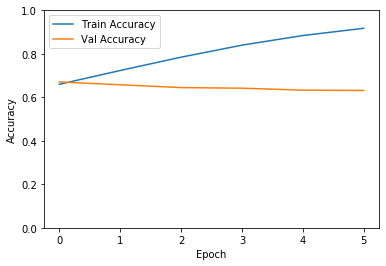

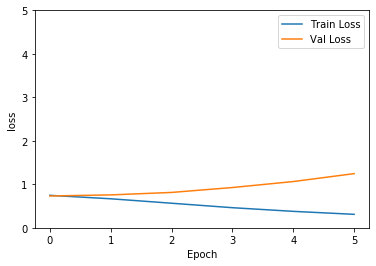

In [44]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
def plot_history(history):
    
      hist = pd.DataFrame(history.history)
      hist['epoch'] = history.epoch

      plt.figure()
      plt.xlabel('Epoch')
      plt.ylabel('Accuracy')
      plt.plot(hist['epoch'], hist['main_out_acc'],
               label='Train Accuracy')
      plt.plot(hist['epoch'], hist['val_main_out_acc'],
               label = 'Val Accuracy')
      plt.ylim([0,1])
      plt.legend()

      plt.figure()
      plt.xlabel('Epoch')
      plt.ylabel('loss')
      plt.plot(hist['epoch'], hist['loss'],
               label='Train Loss')
      plt.plot(hist['epoch'], hist['val_loss'],
               label = 'Val Loss')
      plt.ylim([0,5])
      plt.legend()

      plt.show()
plot_history(history)

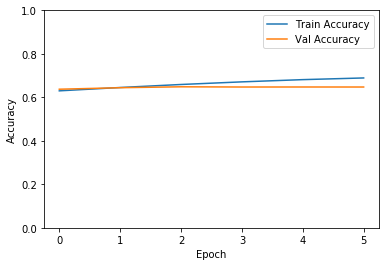

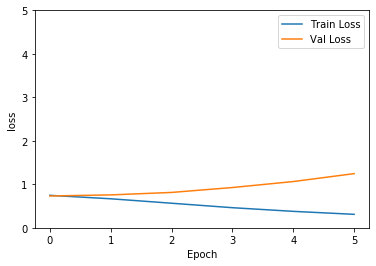

In [45]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
def plot_history(history):
    
      hist = pd.DataFrame(history.history)
      hist['epoch'] = history.epoch

      plt.figure()
      plt.xlabel('Epoch')
      plt.ylabel('Accuracy')
      plt.plot(hist['epoch'], hist['aux_out_acc'],
               label='Train Accuracy')
      plt.plot(hist['epoch'], hist['val_aux_out_acc'],
               label = 'Val Accuracy')
      plt.ylim([0,1])
      plt.legend()

      plt.figure()
      plt.xlabel('Epoch')
      plt.ylabel('loss')
      plt.plot(hist['epoch'], hist['loss'],
               label='Train Loss')
      plt.plot(hist['epoch'], hist['val_loss'],
               label = 'Val Loss')
      plt.ylim([0,5])
      plt.legend()

      plt.show()
plot_history(history)

**Summary:**
I have tried globalaveragepooling1D and by concatenating different other features by merging all these embedding layers and reshaping them to send into the dense layer. I have assigned 1 for all the values which are greater than 0.6 quantile and remaining as zero.whether to check it is "top submission" or not and have acheived main_output accuracy as (67.05) in validation which is higher than no information rate that is (61.85).I have tried by tuning different hyperparameter's and found out 0.01 as decent learning rate.

Aux_out is by working just with text embedding layer and regularizing it to check predictions whereas main_out is considering all the features.

Interesting things:
->First, I thought of not to consider feature of "author" as the unique values are more than 80000 but later on when i have considered,I found out it is increasing the accuracy.